# Sentiment Analysis with an RNN

In this notebook, you'll implement a recurrent neural network that performs sentiment analysis. 
>Using an RNN rather than a strictly feedforward network is more accurate since we can include information about the *sequence* of words. 

Here we'll use a dataset of movie reviews, accompanied by sentiment labels: positive or negative.

<img src="assets/reviews_ex.png" width=40%>

### Network Architecture

The architecture for this network is shown below.

<img src="assets/network_diagram.png" width=40%>

>**First, we'll pass in words to an embedding layer.** We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. You should have seen this before from the Word2Vec lesson. You can actually train an embedding with the Skip-gram Word2Vec model and use those embeddings as input, here. However, it's good enough to just have an embedding layer and let the network learn a different embedding table on its own. *In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representations.*

>**After input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells.** The LSTM cells will add *recurrent* connections to the network and give us the ability to include information about the *sequence* of words in the movie review data. 

>**Finally, the LSTM outputs will go to a sigmoid output layer.** We're using a sigmoid function because positive and negative = 1 and 0, respectively, and a sigmoid will output predicted, sentiment values between 0-1. 

We don't care about the sigmoid outputs except for the **very last one**; we can ignore the rest. We'll calculate the loss by comparing the output at the last time step and the training label (pos or neg).

---
### Load in and visualize the data

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# Give the notebook access to the rest of your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME= '/content/drive/My Drive/ML/Udacity_DLWPT/sentiment-rnn/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


In [3]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# read data from text files
with open(FOLDERNAME + 'data/reviews.txt', 'r') as f:
    reviews = f.read()
with open(FOLDERNAME + 'data/labels.txt', 'r') as f:
    labels = f.read()

In [5]:
print(reviews[:2000])
print()
print(labels[:20])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

## Data pre-processing

The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer. We'll also want to clean it up a bit.

You can see an example of the reviews data above. Here are the processing steps, we'll want to take:
>* We'll want to get rid of periods and extraneous punctuation.
* Also, you might notice that the reviews are delimited with newline characters `\n`. To deal with those, I'm going to split the text into each review using `\n` as the delimiter. 
* Then I can combined all the reviews back together into one big string.

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [6]:
from string import punctuation

print(punctuation)

# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
# split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()

In [8]:
print(words[:30], len(words), sep='\n')

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', 'such', 'as', 'teachers', 'my', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me']
6020196


### Encoding the words

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.

> **Exercise:** Now you're going to encode the words with integers. Build a dictionary that maps words to integers. Later we're going to pad our input vectors with zeros, so make sure the integers **start at 1, not 0**.
> Also, convert the reviews to integers and store the reviews in a new list called `reviews_ints`. 

In [9]:
# feel free to use this import 
from collections import Counter

## Build a dictionary that maps words to integers
vocab_to_int = {word: idx + 1 for idx, word in enumerate(set(words))}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    int_review = [vocab_to_int[word] for word in review.split()]
    reviews_ints.append(int_review)

**Test your code**

As a text that you've implemented the dictionary correctly, print out the number of unique words in your vocabulary and the contents of the first, tokenized review.

In [10]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+

# print tokens in first review
print('Tokenized review: \n', reviews_ints[:1])

Unique words:  74072
Tokenized review: 
 [[60002, 36131, 55626, 18227, 34533, 21448, 18812, 29608, 54775, 62144, 4135, 38035, 52386, 64687, 53271, 28250, 30697, 32390, 3999, 20252, 52386, 50303, 20440, 1650, 34323, 62144, 21795, 2912, 17891, 67416, 17419, 10663, 60282, 60002, 36131, 1528, 59020, 55626, 30181, 22890, 17419, 48092, 15659, 55626, 50303, 62144, 47920, 17419, 42243, 64752, 62144, 11894, 50334, 4298, 22131, 6548, 60271, 2517, 38245, 41470, 50303, 59340, 62144, 26489, 66784, 62144, 14475, 14319, 52910, 66254, 67416, 66784, 62144, 505, 65842, 13083, 46692, 38245, 50334, 385, 65842, 35601, 62144, 10305, 34323, 31727, 18227, 55166, 67083, 72327, 17419, 51665, 45187, 62144, 32390, 65842, 32903, 1347, 54775, 36131, 18227, 60775, 41381, 31666, 65842, 14334, 44361, 17419, 11670, 60950, 66784, 15266, 50303, 55166, 26392, 17419, 60002, 36131, 65842, 12340, 60282, 53439, 24997, 66784, 20440, 19524, 74029, 60282, 60002, 36131, 55626, 5261, 23365, 48182, 18227, 13879, 60282, 18812, 3795,

### Encoding the labels

Our labels are "positive" or "negative". To use these labels in our network, we need to convert them to 0 and 1.

> **Exercise:** Convert labels from `positive` and `negative` to 1 and 0, respectively, and place those in a new list, `encoded_labels`.

In [11]:
# 1=positive, 0=negative label conversion
encoded_labels = [1 if label =='positive' else 0 for label in labels.split('\n')]
print(encoded_labels[:5], labels.split('\n')[:5], sep='\n')

[1, 0, 1, 0, 1]
['positive', 'negative', 'positive', 'negative', 'positive']


The data set is very nearly balanced.

In [12]:
sum(encoded_labels) / len(encoded_labels)

0.499980000799968

### Removing Outliers

As an additional pre-processing step, we want to make sure that our reviews are in good shape for standard processing. That is, our network will expect a standard input text size, and so, we'll want to shape our reviews into a specific length. We'll approach this task in two main steps:

1. Getting rid of extremely long or short reviews; the outliers
2. Padding/truncating the remaining data so that we have reviews of the same length.

<img src="assets/outliers_padding_ex.png" width=40%>

Before we pad our review text, we should check for reviews of extremely short or long lengths; outliers that may mess with our training.

In [13]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


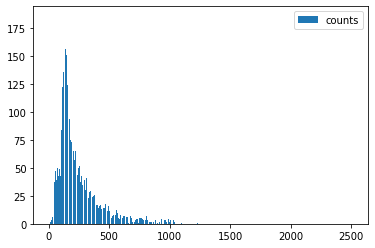

In [14]:
# Plot the distribution
fix, ax = plt.subplots()
ax.bar(list(review_lens.keys()), review_lens.values(), label='counts')
ax.legend()

In [15]:
review_lens_np = np.array(list(review_lens.values()))
print(review_lens_np.mean(), review_lens_np.std())

24.39121951219512 35.345377742798036


Okay, a couple issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. We'll have to remove any super short reviews and truncate super long reviews. This removes outliers and should allow our model to train more efficiently.

> **Exercise:** First, remove *any* reviews with zero length from the `reviews_ints` list and their corresponding label in `encoded_labels`.

In [16]:
# I'm just going to take care of this in the padding function

---
## Padding sequences

To deal with both short and very long reviews, we'll pad or truncate all our reviews to a specific length. For reviews shorter than some `seq_length`, we'll pad with 0s. For reviews longer than `seq_length`, we can truncate them to the first `seq_length` words. A good `seq_length`, in this case, is 200.

> **Exercise:** Define a function that returns an array `features` that contains the padded data, of a standard size, that we'll pass to the network. 
* The data should come from `review_ints`, since we want to feed integers to the network. 
* Each row should be `seq_length` elements long. 
* For reviews shorter than `seq_length` words, **left pad** with 0s. That is, if the review is `['best', 'movie', 'ever']`, `[117, 18, 128]` as integers, the row will look like `[0, 0, 0, ..., 0, 117, 18, 128]`. 
* For reviews longer than `seq_length`, use only the first `seq_length` words as the feature vector.

As a small example, if the `seq_length=10` and an input review is: 
```
[117, 18, 128]
```
The resultant, padded sequence should be: 

```
[0, 0, 0, 0, 0, 0, 0, 117, 18, 128]
```

**Your final `features` array should be a 2D array, with as many rows as there are reviews, and as many columns as the specified `seq_length`.**

This isn't trivial and there are a bunch of ways to do this. But, if you're going to be building your own deep learning networks, you're going to have to get used to preparing your data.

In [17]:
def filtered_padded_data(reviews_ints, seq_length, min_len=0, max_len=float('inf')):
    """Return features of review_ints, where each review is padded with 0's 
    or truncated to the input seq_length.
    """
    print('Initial number of reviews: ', len(reviews_ints))
    ## remove any reviews shorter than min_len or longer than max_len
    np_review_lengths = np.array([len(review) for review in reviews_ints])
    np_reviews_ints = np.array(reviews_ints)
    filtered_indices = np.logical_and(np_review_lengths > 0, np_review_lengths < max_len)
    reviews_ints_filtered = np.array(reviews_ints)
    reviews_ints_filtered = reviews_ints_filtered[filtered_indices].tolist()
    encoded_labels_filtered = np.array(encoded_labels)
    encoded_labels_filtered = encoded_labels_filtered[filtered_indices]

    print('Number of reviews after filtering: ', len(reviews_ints_filtered))
    
    features = []
    for review in reviews_ints_filtered:
        if len(review) < seq_length:
            len_diff = seq_length - len(review)
            features.append(len_diff * [0] + review)
        else:
            features.append(review[:seq_length])
    
    return np.array(features), encoded_labels_filtered

In [18]:
# Test your implementation!

seq_length = 200

features, labels = filtered_padded_data(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features[0]) == seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches 
print(features[:30,:10])

Initial number of reviews:  25001
Number of reviews after filtering:  25000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [64729 41870 25401 52386  4159  8954 59214 57995 28990 56871]
 [ 3440 67132 52386 18227 69514 70242 67605 24065 55626 53400]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [  385 65842 50449  5674 20440 69495 55453 67416   364 17419]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [62144  4127 35442 32995 18227 70242 61254 40163 34323 36784]
 [34323    45 28222 33213 24487  7755  4491  3430 66341 14445]
 [    0     0     0     0     0     0     0     0     0

## Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets.

> **Exercise:** Create the training, validation, and test sets. 
* You'll need to create sets for the features and the labels, `train_x` and `train_y`, for example. 
* Define a split fraction, `split_frac` as the fraction of data to **keep** in the training set. Usually this is set to 0.8 or 0.9. 
* Whatever data is left will be split in half to create the validation and *testing* data.

In [19]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
# Get index range, shuffle, and split
indices = np.arange(len(features))
np.random.shuffle(indices)
train_idx = int(split_frac * len(indices))
train_x, remainder_x = features[:train_idx], features[train_idx:]
train_y, remainder_y = labels[:train_idx], labels[train_idx:]

val_idx = int(len(remainder_x) / 2)
val_x, test_x = remainder_x[:val_idx], remainder_x[val_idx:]
val_y, test_y = remainder_y[:val_idx], remainder_y[val_idx:]

## print out the shapes of your resultant feature data
for arr in (train_x, train_y, val_x, val_y, test_x, test_y):
    print(arr.shape)

(20000, 200)
(20000,)
(2500, 200)
(2500,)
(2500, 200)
(2500,)


**Check your work**

With train, validation, and test fractions equal to 0.8, 0.1, 0.1, respectively, the final, feature data shapes should look like:
```
                    Feature Shapes:
Train set: 		 (20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		  (2500, 200)
```

---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets.

```
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, batch_size=batch_size)
```

This is an alternative to creating a generator function for batching our data into full batches.

In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 512

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [21]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([512, 200])
Sample input: 
 tensor([[ 3137, 15149,  1528,  ..., 39595, 66784, 26703],
        [    0,     0,     0,  ..., 41796, 62144, 24087],
        [    0,     0,     0,  ..., 66784,    45, 67283],
        ...,
        [    0,     0,     0,  ..., 52871, 10311, 57094],
        [    0,     0,     0,  ...,  6386,    45, 49243],
        [    0,     0,     0,  ..., 55906,  1528, 72911]])

Sample label size:  torch.Size([512])
Sample label: 
 tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 

---
# Sentiment Network with PyTorch

Below is where you'll define the network.

<img src="assets/network_diagram.png" width=40%>

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired seq_length4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer

We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are 74000+ words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.


### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

Most of the time, your network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships. 

> **Exercise:** Complete the `__init__`, `forward`, and `init_hidden` functions for the SentimentRNN model class.

Note: `init_hidden` should initialize the hidden and cell state of an lstm layer to all zeros, and move those state to GPU, if available.

GG: This is a pretty poor model since, for example, it doesn't use bidirectionality and only uses the final LSTM output, but going to just follow Udacity here, per the lesson.

In [22]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self,
                 vocab_size, 
                 embedding_dim,
                 hidden_dim,
                 n_layers,
                 drop_prob=0.2,
                 device=torch.device('cpu')):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.drop_prob = drop_prob
        self.vocab_size = vocab_size
        self.device = device

        # define all layers
        self.embedding = nn.Embedding(self.vocab_size,
                                      self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            num_layers=self.n_layers,
                            batch_first=True,
                            dropout=self.drop_prob,
                            hidden_size = self.hidden_dim)
        self.dropout = nn.Dropout(p=self.drop_prob)
        # Single output feature between 0 and 1
        self.linear = nn.Linear(in_features=self.hidden_dim,
                                out_features=1)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        # Take last time step of the LSTM
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.linear(x).view(x.shape[0])        
        return x, hidden
    
    def init_hidden(self, batch_size):
        # Initializes hidden state 
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        # Create instance of Parameter class to overwrite
        weight = next(self.parameters()) 
        hidden = (weight.new_zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device),
                  weight.new_zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device))
        return hidden
        

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `seq_length`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

> **Exercise:** Define the model  hyperparameters.


In [23]:
# Instantiate the model w/ hyperparams
net_dict = {'vocab_size': len(vocab_to_int) + 1,
            'embedding_dim': 1024,
            'hidden_dim': 1024,
            'n_layers': 2,
            'drop_prob': .75,
            'device': device}

net = SentimentRNN(**net_dict)
net.to(device)

SentimentRNN(
  (embedding): Embedding(74073, 1024)
  (lstm): LSTM(1024, 1024, num_layers=2, batch_first=True, dropout=0.75)
  (dropout): Dropout(p=0.75, inplace=False)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)

In [24]:
# Testing
net_test = SentimentRNN(**net_dict)
net_test.to(device)
sample_x = sample_x.to(device)
print('Output shape and device')
print(net_test(sample_x, net_test.init_hidden(batch_size=batch_size))[0].shape)
print(net_test(sample_x, net_test.init_hidden(batch_size=batch_size))[0].device)
print('Hidden shapes and devices')
print(*(item.shape for item in net_test(sample_x, net_test.init_hidden(batch_size=batch_size))[1]))
print(*(item.device for item in net_test(sample_x, net_test.init_hidden(batch_size=batch_size))[1]))

Output shape and device
torch.Size([512])
cuda:0
Hidden shapes and devices
torch.Size([2, 512, 1024]) torch.Size([2, 512, 1024])
cuda:0 cuda:0


---
## Training

Below is the typical training code. If you want to do this yourself, feel free to delete all this code and implement it yourself. You can also add code to save a model by name.

>We'll also be using a new kind of cross entropy loss, which is designed to work with a single Sigmoid output. [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss), or **Binary Cross Entropy Loss**, applies cross entropy loss to a single value between 0 and 1.

We also have some data and training hyparameters:

* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [27]:
# loss and optimization functions
lr=0.0003
# Instantiate the model w/ hyperparams
net_dict = {'vocab_size': len(vocab_to_int) + 1,
            'embedding_dim': 1024,
            'hidden_dim': 1024,
            'n_layers': 2,
            'drop_prob': .75,
            'device': device}

net = SentimentRNN(**net_dict)
net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay = 1e-5)
best_val_loss = np.inf

In [28]:
# training params

epochs = 7

counter = 0
print_every = 10
clip = 5 # gradient clipping

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        
        inputs, labels = inputs.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.detach() for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if not counter % print_every:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.detach().to(device) for each in val_h])
                inputs, labels = inputs.to(device), labels.to(device)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())
            mean_val_loss = np.mean(val_losses)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                print(f'Saving model with loss {best_val_loss.item()}')
                torch.save(net.state_dict(), 'model.pth')

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Saving model with loss 0.6857346445322037
Epoch: 1/7... Step: 10... Loss: 0.682178... Val Loss: 0.685735
Saving model with loss 0.6544013917446136
Epoch: 1/7... Step: 20... Loss: 0.654969... Val Loss: 0.654401
Saving model with loss 0.6380369514226913
Epoch: 1/7... Step: 30... Loss: 0.625915... Val Loss: 0.638037
Epoch: 2/7... Step: 40... Loss: 0.621749... Val Loss: 0.638368
Saving model with loss 0.582636758685112
Epoch: 2/7... Step: 50... Loss: 0.555736... Val Loss: 0.582637
Saving model with loss 0.561036542057991
Epoch: 2/7... Step: 60... Loss: 0.545512... Val Loss: 0.561037
Epoch: 2/7... Step: 70... Loss: 0.576577... Val Loss: 0.586535
Saving model with loss 0.532298356294632
Epoch: 3/7... Step: 80... Loss: 0.432911... Val Loss: 0.532298
Saving model with loss 0.4908098801970482
Epoch: 3/7... Step: 90... Loss: 0.466345... Val Loss: 0.490810
Epoch: 3/7... Step: 100... Loss: 0.436174... Val Loss: 0.518905
Epoch: 3/7... Step: 110... Loss: 0.497319... Val Loss: 0.502534
Saving model w

In [29]:
net.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

---
## Testing

There are a few ways to test your network.

* **Test data performance:** First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data.

* **Inference on user-generated data:** Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts. Looking at new, user input data like this, and predicting an output label, is called **inference**.

In [30]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.sigmoid().squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.to('cpu').numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.470
Test accuracy: 0.657


### Inference on a test review

You can change this test_review to any text that you want. Read it and think: is it pos or neg? Then see if your model predicts correctly!
    
> **Exercise:** Write a `predict` function that takes in a trained net, a plain text_review, and a sequence length, and prints out a custom statement for a positive or negative review!
* You can use any functions that you've already defined or define any helper functions you want to complete `predict`, but it should just take in a trained net, a text review, and a sequence length.


In [31]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'

In [32]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    # use .get() to handle words not in the vocabulary (such words mapped to zero).
    test_ints.append([vocab_to_int.get(word, 0) for word in test_words])

    return test_ints

# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[62144, 40315, 45810, 65842, 51878, 19348, 64015, 50449, 43590, 46692, 65842, 64332, 20440, 12414, 73196, 45, 45810, 53447, 12723, 64015, 46692, 62144, 34453, 50449, 41262]]


In [33]:
def pad_features(reviews_ints, seq_length):
    """Return features of review_ints, where each review is padded with 0's 
    or truncated to the input seq_length.
    """
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [34]:
# test sequence padding
seq_length=200
features = pad_features(test_ints, seq_length)

print(features)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

In [35]:
# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

torch.Size([1, 200])


In [36]:
def predict(net, test_review, sequence_length=200, device=device):
    
    net.eval()
    
    # tokenize review
    test_ints = tokenize_review(test_review)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # initialize hidden state
    h = net.init_hidden(batch_size)
    
    feature_tensor = feature_tensor.to(device)
    
    # get the output from the model
    output, h = net(feature_tensor, h)
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.sigmoid().squeeze()) 
    # printing output value, before rounding
    print('Prediction value, pre-rounding: {:.6f}'.format(output.sigmoid().item()))
    
    # print custom response
    if(pred.item()==1):
        print("Positive review detected!")
    else:
        print("Negative review detected.")
        

In [37]:
# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'


In [38]:
predict(net, test_review_neg, seq_length)

Prediction value, pre-rounding: 0.011518
Negative review detected.


In [39]:
predict(net, test_review_pos, seq_length)

Prediction value, pre-rounding: 0.951054
Positive review detected!


Testing that unrecognized words turn into padding:

In [40]:
def test_ints(s):
  # tokenize review
    test_ints = tokenize_review(s)
    
    features = pad_features(test_ints, 20)
    return features

In [41]:
test_ints('this is a review')

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    45, 55626,
        18227, 29747]])

In [42]:
test_ints('asd asdf sadf asfd')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])